In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
import cv2
import tensorflow as tf
import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge,Lasso

from keras.models import Sequential
from keras.layers import Flatten, Dropout
from keras.layers.core import Dense
from keras.optimizers import RMSprop,Adam,SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import Normalizer

sns.set()

In [239]:
url='/content/energy_train.csv'
df_train = pd.read_csv(url)
df_train.head()

,id,date,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2
0,1,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,3,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,4,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,5,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,NaN,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [240]:
url='/content/energy_test.csv'
df_test = pd.read_csv(url)
df_test.head()

,id,date,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2
0,15001,2016-04-24 21:00:00,0,21.926667,35.5,19.2900,37.500000,22.39,34.000000,21.39,32.225714,20.5,40.79,3.466667,37.660000,21.890000,29.976000,24.390000,35.700000,20.200000,NaN,4.10,758.00,82.000000,3.0,40.0,1.2,10.668196,10.668196
1,15002,2016-04-24 21:10:00,0,21.890000,35.4,19.2225,37.425000,22.39,34.090000,21.35,32.200000,20.5,40.79,3.326667,39.526667,21.890000,30.100000,24.390000,35.730000,20.200000,32.400000,3.95,758.05,82.166667,3.0,40.0,1.1,48.467852,48.467852
2,15003,2016-04-24 21:20:00,0,21.890000,35.4,19.2000,37.466667,22.39,33.963333,21.29,32.277143,20.5,40.70,3.290000,41.533333,21.830000,30.140000,24.323333,35.863333,20.200000,32.290000,3.80,758.10,82.333333,3.0,40.0,1.0,36.388536,36.388536
3,15004,2016-04-24 21:30:00,0,21.890000,35.4,19.1000,37.590000,22.39,33.900000,21.29,32.334000,20.5,40.70,3.290000,42.533333,21.804286,30.212857,24.390000,35.933333,20.175000,32.290000,3.65,758.15,82.500000,3.0,40.0,0.9,17.198176,17.198176
4,15005,2016-04-24 21:40:00,0,21.890000,35.4,19.1000,37.590000,22.39,33.966667,21.29,32.290000,20.5,40.70,3.060000,43.396667,21.790000,30.456000,24.323333,36.133333,20.166667,32.563333,3.50,758.20,82.666667,3.0,40.0,0.8,7.200588,7.200588


In [241]:
df_train['source']='train'
df_test['source']='test'
print(df_train.head(3))
print(df_test.head(3))

   id                 date  ...  random_variable_2  source
0   1  2016-01-11 17:00:00  ...          13.275433   train
1   2  2016-01-11 17:10:00  ...          18.606195   train
2   3  2016-01-11 17:20:00  ...          28.642668   train

[3 rows x 31 columns]
      id                 date  ...  random_variable_2  source
0  15001  2016-04-24 21:00:00  ...          10.668196    test
1  15002  2016-04-24 21:10:00  ...          48.467852    test
2  15003  2016-04-24 21:20:00  ...          36.388536    test

[3 rows x 30 columns]


In [242]:
df = pd.concat([df_train,df_test],axis=0,ignore_index=True)
df

,id,date,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source
0,1,2016-01-11 17:00:00,60.0,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.200000,48.900000,17.033333,45.530000,6.600000,733.500000,92.0,7.000000,63.000000,5.300000,13.275433,13.275433,train
1,2,2016-01-11 17:10:00,60.0,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.200000,48.863333,17.066667,45.560000,6.483333,733.600000,92.0,6.666667,59.166667,5.200000,18.606195,18.606195,train
2,3,2016-01-11 17:20:00,50.0,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.200000,48.730000,17.000000,45.500000,6.366667,733.700000,92.0,6.333333,55.333333,5.100000,28.642668,28.642668,train
3,4,2016-01-11 17:30:00,50.0,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.100000,48.590000,17.000000,45.400000,6.250000,733.800000,92.0,6.000000,51.500000,5.000000,45.410389,45.410389,train
4,5,2016-01-11 17:40:00,60.0,40,19.890000,46.333333,19.200000,44.530000,NaN,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.100000,48.590000,17.000000,45.400000,6.133333,733.900000,92.0,5.666667,47.666667,4.900000,10.084097,10.084097,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,19371,2016-05-25 05:20:00,NaN,10,23.600000,40.833333,20.856667,43.566667,25.260000,39.266667,23.500000,39.000000,19.700000,39.081250,5.563333,41.600000,23.000000,35.090000,24.171429,43.264286,22.600000,44.790000,6.166667,757.133333,95.0,1.000000,24.666667,5.433333,43.792662,43.792662,test
19371,19372,2016-05-25 05:30:00,NaN,0,23.666667,40.566667,20.790000,43.700000,25.133333,38.666667,23.500000,38.933333,19.657143,40.410000,5.763333,42.193333,23.000000,35.090000,24.160000,43.400000,22.600000,44.760000,6.150000,757.100000,95.5,1.000000,24.500000,5.500000,22.151890,22.151890,test
19372,19373,2016-05-25 05:40:00,NaN,0,23.600000,40.093333,20.700000,43.296667,24.963333,37.833333,23.463333,38.563333,19.680000,41.094000,6.123333,43.066667,22.926667,35.090000,24.100000,43.324286,22.600000,44.760000,6.133333,757.066667,96.0,1.000000,24.333333,5.566667,5.759009,5.759009,test
19373,19374,2016-05-25 05:50:00,NaN,0,23.600000,39.426667,20.633333,42.830000,24.823333,37.566667,23.390000,38.096667,19.600000,41.108571,6.330000,43.526667,22.945000,35.045000,24.100000,43.254000,22.600000,44.700000,6.116667,757.033333,96.5,1.000000,24.166667,5.633333,13.711184,13.711184,test


In [0]:
def secSinceNoon(datTimStr):
    tt = pd.to_datetime(datTimStr).time()
    return tt.hour * 3600 + tt.minute * 60 + tt.second

In [0]:
df['timestamp'] = pd.to_datetime(df['date'])


In [245]:
df['timestamp']

0       2016-01-11 17:00:00
1       2016-01-11 17:10:00
2       2016-01-11 17:20:00
3       2016-01-11 17:30:00
4       2016-01-11 17:40:00
                ...        
19370   2016-05-25 05:20:00
19371   2016-05-25 05:30:00
19372   2016-05-25 05:40:00
19373   2016-05-25 05:50:00
19374   2016-05-25 06:00:00
Name: timestamp, Length: 19375, dtype: datetime64[ns]

In [246]:
df['SSM'] = df['timestamp'].apply(secSinceNoon)
df['SSM']

0        61200
1        61800
2        62400
3        63000
4        63600
         ...  
19370    19200
19371    19800
19372    20400
19373    21000
19374    21600
Name: SSM, Length: 19375, dtype: int64

In [247]:
df['SSM'].value_counts()

16200    135
15600    135
76800    135
12000    135
78000    135
        ... 
25200    134
45600    134
29400    134
41400    134
26400    134
Name: SSM, Length: 144, dtype: int64

In [248]:
df_train.shape

(15000, 31)

In [249]:
df_test.shape

(4375, 30)

In [250]:
df.isnull().sum().sort_values(ascending=False)

moisture_9           4601
WattHour             4375
degree_C1            3918
degree_C3            2308
SSM                     0
moisture_3              0
moisture_5              0
degree_C5               0
moisture_4              0
degree_C4               0
moisture_2              0
moisture_6              0
degree_C2               0
moisture_1              0
luminousity             0
date                    0
degree_C6               0
degree_C7               0
timestamp               0
moisture_7              0
degree_C8               0
moisture_8              0
degree_C9               0
degree_Cout             0
Pressure                0
moisture_out            0
Wind                    0
Clarity                 0
dew_index               0
random_variable_1       0
random_variable_2       0
source                  0
id                      0
dtype: int64

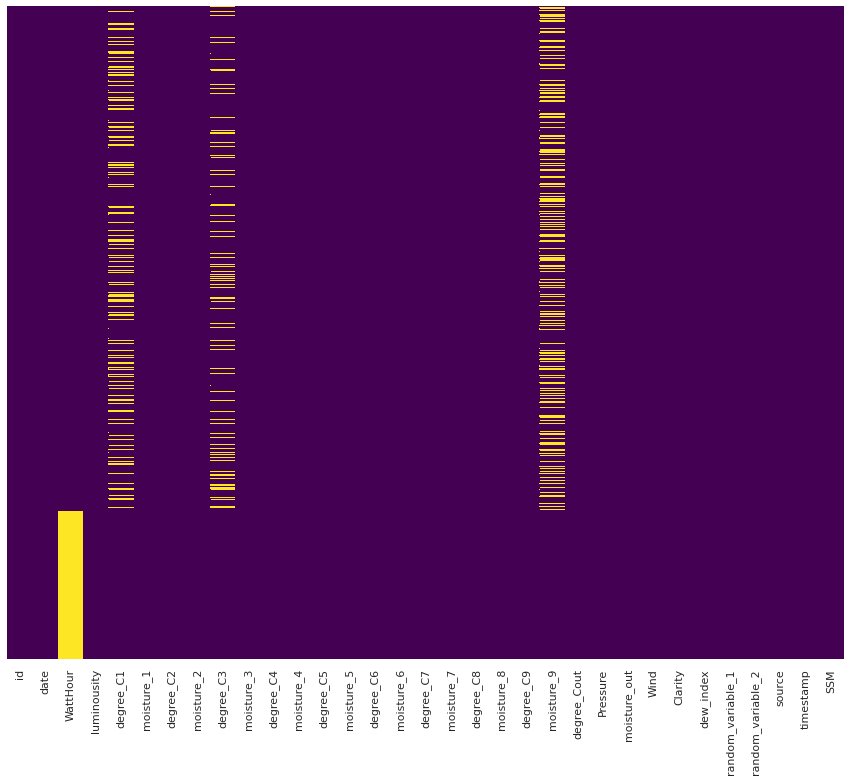

In [251]:
plt.figure(figsize=(15,12))
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='viridis')
plt.show()

In [252]:
df.describe()
#luminoisity may tend to be categorical as 75%data is 0
#moisture_1 and degree_c2 are +vely skewed but shoot up in 75% - 100% value
#MISSING=> degree_c1 makes sense to fill up with mean or find a categorical mean-way as normal distributn n not much skewness
#watthour- highly +vely skewed due to also very high std
#moisture_2 is okayish but can be issue as 75% -1005 value shoots up
#MISSING=> degree_3 is also good to go with mean_values or find a categorical mean-way as normal distributn n not much skewness
#moisture_3,degree_c4,moisture_4,deg_c4,deg_c5 - good to go..normal distributn
#moisture_5 is a bit +vely skewed, but good to go as it averages out better
#degree_c6 has -ve values, and its +vely skewed b/w 75-100%
#moisture_6 is okay but min-25% gap is large
#deg_c7 is good to go- normal distrbn
#moisture_c7 is okay
#deg_c8,moisture_c8,deg_c9 is perf- normal dstrbn
#MISSING => moisture_c9 is also good to go with mean_values or find a categorical mean-way as normal distributn n not much skewness
#deg_cout has -ve values n check for skewness , mostly +vely skewed b/w 75-100%
#pressure,moisture_out - is god but might be a bit -vely skewed b/w 0-25% -> hihghly dependent asinp
#wind has 0 values , whihc may need to be given equal to min values, but distribn is okay
#clarity- 50% and 75% val is same, high std, might hv issues
#dew_index is +ve skewed b/w 75%-100% , mean is okay so mostly  okay
#random_vals1,2 have the same variable values and distrubn. need to look closely


,id,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,SSM
count,19375.000000,15000.000000,19375.000000,15457.000000,19375.000000,19375.000000,19375.000000,17067.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,14774.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000
mean,9688.000000,98.751333,3.827097,21.774405,40.220157,20.270352,40.436162,22.286325,39.245984,20.793050,38.991712,19.553927,50.916531,7.724643,55.335967,20.205494,35.317410,21.992285,42.900976,19.430763,41.470871,7.269959,755.506795,79.879819,4.081445,38.312439,3.650808,24.995042,24.995042,42905.032258
std,5593.225068,106.421877,7.959848,1.633328,3.980203,2.137612,4.071491,1.985984,3.277591,2.008673,4.361701,1.834503,9.036005,5.958490,30.890658,2.078640,5.107973,1.954581,5.240796,1.991188,4.225365,5.229336,7.466514,14.827780,2.452072,11.710588,4.143122,14.489339,14.489339,24974.714641
min,1.000000,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000
25%,4844.500000,50.000000,0.000000,20.790000,37.290000,18.790000,37.924167,20.790000,36.863333,19.500000,35.466667,18.230000,45.363333,3.560000,31.239167,18.700000,31.390000,20.760000,39.020143,18.000000,38.430000,3.583333,750.833333,70.666667,2.000000,29.000000,0.850000,12.513515,12.513515,21000.000000
50%,9688.000000,60.000000,0.000000,21.700000,39.590000,19.926667,40.500000,22.100000,38.530000,20.600000,38.363333,19.326667,49.000000,7.133333,55.966667,20.000000,34.790000,22.100000,42.321429,19.356667,40.760000,6.800000,756.033333,84.000000,3.666667,40.000000,3.350000,24.909493,24.909493,43200.000000
75%,14531.500000,100.000000,0.000000,22.760000,43.000000,21.390000,43.290000,23.360000,41.790000,22.000000,42.098333,20.600000,53.660000,10.963333,83.598333,21.500000,38.966667,23.290000,46.500000,20.500000,44.290000,10.266667,761.066667,91.666667,5.500000,40.000000,6.300000,37.580389,37.580389,64800.000000
max,19375.000000,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,85800.000000


In [253]:
df.apply(lambda x: len(x.unique()))
#as said luminousity may be categorial, lets check

id                   19375
date                 19375
WattHour                92
luminousity              8
degree_C1              614
moisture_1            2456
degree_C2             1513
moisture_2            3176
degree_C3             1254
moisture_3            2529
degree_C4             1312
moisture_4            2898
degree_C5             2171
moisture_5            7411
degree_C6             4269
moisture_6            9578
degree_C7             1854
moisture_7            5734
degree_C8             2148
moisture_8            6539
degree_C9              908
moisture_9            3008
degree_Cout           1710
Pressure              2183
moisture_out           560
Wind                   189
Clarity                405
dew_index             1403
random_variable_1    19375
random_variable_2    19375
source                   2
timestamp            19375
SSM                    144
dtype: int64

In [254]:
df['luminousity'].unique()

array([30, 40, 50, 70, 60, 10, 20,  0])

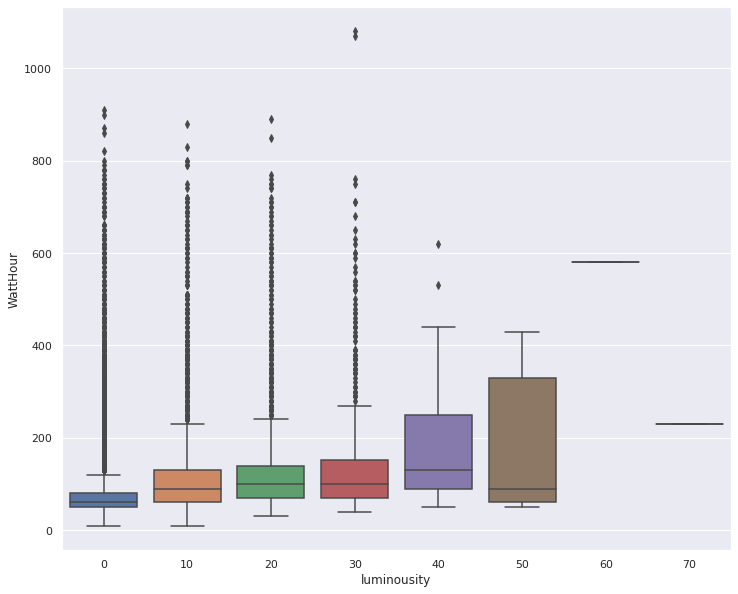

In [255]:
plt.figure(figsize=(12,10))
sns.boxplot(x=df['luminousity'],y=df['WattHour'])
plt.show()

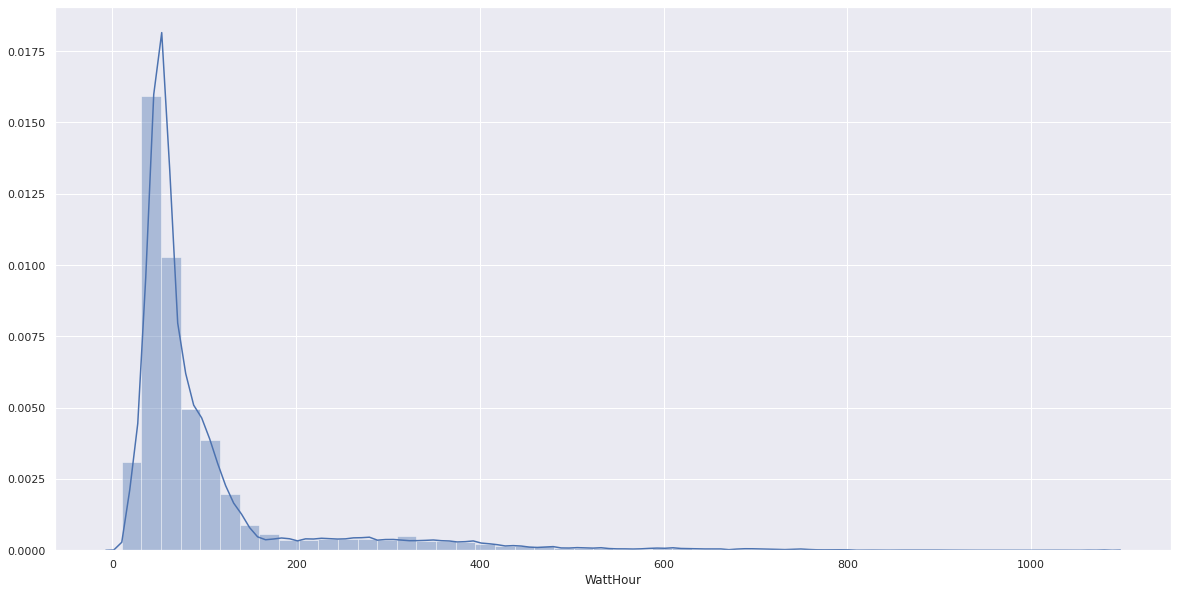

In [256]:
plt.figure(figsize=(20,10))
sns.distplot(df['WattHour'])
plt.show()

In [257]:
df['luminousity'].value_counts()

0     14944
10     2192
20     1596
30      555
40       77
50        9
60        1
70        1
Name: luminousity, dtype: int64

In [258]:
df[df['luminousity']==70]

,id,date,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source,timestamp,SSM
10,11,2016-01-11 18:40:00,230.0,70,19.926667,45.863333,19.356667,44.4,19.79,44.9,18.89,46.43,17.1,55.0,6.19,87.866667,17.2475,42.7175,18.1,48.59,17.0,45.29,5.966667,734.366667,91.333333,5.666667,40.0,4.633333,10.298729,10.298729,train,2016-01-11 18:40:00,67200


In [259]:
corr = df.corr().round(2)
corr

,id,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,SSM
id,1.00,-0.00,-0.19,0.69,-0.12,0.49,-0.09,0.79,-0.44,0.77,-0.29,0.77,-0.25,0.58,-0.82,0.83,-0.20,0.78,-0.30,0.88,-0.23,0.57,-0.03,-0.34,-0.24,-0.10,0.45,0.00,0.00,-0.00
WattHour,-0.00,1.00,0.22,0.09,0.09,0.16,-0.06,0.13,0.03,0.07,-0.00,0.03,-0.00,0.12,-0.08,0.05,-0.07,0.07,-0.12,0.03,-0.07,0.10,-0.04,-0.15,0.08,-0.01,0.02,-0.01,-0.01,0.23
luminousity,-0.19,0.22,1.00,-0.04,0.11,0.00,0.05,-0.10,0.13,-0.00,0.12,-0.08,0.14,-0.07,0.15,-0.13,0.04,-0.07,0.01,-0.16,-0.02,-0.07,-0.01,0.07,0.06,0.02,-0.03,0.00,0.00,0.26
degree_C1,0.69,0.09,-0.04,1.00,0.18,0.84,0.01,0.90,-0.00,0.88,0.11,0.89,-0.02,0.66,-0.61,0.85,0.15,0.83,0.01,0.85,0.13,0.70,-0.16,-0.35,-0.08,-0.08,0.58,-0.00,-0.00,0.17
moisture_1,-0.12,0.09,0.11,0.18,1.00,0.26,0.80,0.26,0.85,0.09,0.88,0.19,0.30,0.31,0.26,0.00,0.80,-0.04,0.73,0.10,0.77,0.33,-0.30,0.29,0.22,-0.03,0.64,0.00,0.00,0.02
degree_C2,0.49,0.16,0.00,0.84,0.26,1.00,-0.16,0.73,0.12,0.75,0.22,0.72,0.02,0.79,-0.56,0.65,0.21,0.57,0.06,0.66,0.16,0.78,-0.14,-0.51,0.09,-0.07,0.57,-0.01,-0.01,0.26
moisture_2,-0.09,-0.06,0.05,0.01,0.80,-0.16,1.00,0.15,0.68,-0.04,0.73,0.11,0.25,0.00,0.39,-0.05,0.70,-0.04,0.68,0.06,0.69,0.04,-0.26,0.59,0.07,-0.01,0.52,0.01,0.01,-0.18
degree_C3,0.79,0.13,-0.10,0.90,0.26,0.73,0.15,1.00,0.00,0.85,0.13,0.89,-0.08,0.68,-0.64,0.85,0.17,0.80,0.05,0.90,0.17,0.70,-0.21,-0.27,-0.08,-0.11,0.65,-0.00,-0.00,0.04
moisture_3,-0.44,0.03,0.13,-0.00,0.85,0.12,0.68,0.00,1.00,-0.14,0.90,-0.05,0.38,0.08,0.52,-0.26,0.84,-0.29,0.83,-0.20,0.84,0.12,-0.23,0.36,0.27,0.01,0.42,-0.00,-0.00,-0.05
degree_C4,0.77,0.07,-0.00,0.88,0.09,0.75,-0.04,0.85,-0.14,1.00,-0.07,0.87,-0.09,0.64,-0.69,0.87,0.02,0.79,-0.11,0.88,0.00,0.65,-0.08,-0.39,-0.16,-0.11,0.50,-0.00,-0.00,0.09


In [260]:
#cleaning deg_c1,deg_c3,moisture_c9

mean_deg_c1 = df.groupby('SSM').mean()['degree_C1']
mean_deg_c1


SSM
0        22.188079
600      22.126081
1200     22.002477
1800     22.054034
2400     22.012346
           ...    
83400    22.312394
84000    22.218751
84600    22.197093
85200    22.134036
85800    22.191759
Name: degree_C1, Length: 144, dtype: float64

In [261]:
miss_bool = df['degree_C1'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
df.loc[miss_bool,'degree_C1'] = df.loc[miss_bool,'SSM'].apply(lambda x: mean_deg_c1[x])
df['degree_C1'].isnull().sum()

0

In [262]:

mean_deg_c3 = df.groupby('SSM').mean()['degree_C3']
mean_deg_c3


SSM
0        22.306176
600      22.283513
1200     22.312552
1800     22.356264
2400     22.346907
           ...    
83400    22.403216
84000    22.345004
84600    22.313712
85200    22.319813
85800    22.303232
Name: degree_C3, Length: 144, dtype: float64

In [263]:
miss_bool = df['degree_C3'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
df.loc[miss_bool,'degree_C3'] = df.loc[miss_bool,'SSM'].apply(lambda x: mean_deg_c3[x])
df['degree_C3'].isnull().sum()

0

In [264]:

mean_moisture_9 = df.groupby('SSM').mean()['moisture_9']
mean_moisture_9

SSM
0        41.409378
600      41.603296
1200     41.285473
1800     41.522608
2400     41.975621
           ...    
83400    40.897239
84000    40.805052
84600    41.265355
85200    41.265251
85800    41.371603
Name: moisture_9, Length: 144, dtype: float64

In [265]:
miss_bool = df['moisture_9'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
df.loc[miss_bool,'moisture_9'] = df.loc[miss_bool,'SSM'].apply(lambda x: mean_moisture_9[x])
df['moisture_9'].isnull().sum()

0

In [266]:
df.isnull().sum().sort_values(ascending=False)

WattHour             4375
SSM                     0
moisture_6              0
date                    0
luminousity             0
degree_C1               0
moisture_1              0
degree_C2               0
moisture_2              0
degree_C3               0
moisture_3              0
degree_C4               0
moisture_4              0
degree_C5               0
moisture_5              0
degree_C6               0
degree_C7               0
timestamp               0
moisture_7              0
degree_C8               0
moisture_8              0
degree_C9               0
moisture_9              0
degree_Cout             0
Pressure                0
moisture_out            0
Wind                    0
Clarity                 0
dew_index               0
random_variable_1       0
random_variable_2       0
source                  0
id                      0
dtype: int64

In [267]:
min_wind_value = df[df['Wind']!=0]['Wind'].min()
min_wind_value

0.166666666666667

In [268]:
filt = df['Wind'] == 0
df.loc[filt,'Wind'] = min_wind_value
df[df['Wind']==0]

,id,date,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source,timestamp,SSM


In [0]:
df.drop(['luminousity'],axis=1,inplace=True)

In [270]:
df.head()

,id,date,WattHour,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source,timestamp,SSM
0,1,2016-01-11 17:00:00,60.0,19.89,47.596667,19.2,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,train,2016-01-11 17:00:00,61200
1,2,2016-01-11 17:10:00,60.0,19.89,46.693333,19.2,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,train,2016-01-11 17:10:00,61800
2,3,2016-01-11 17:20:00,50.0,19.89,46.300000,19.2,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,train,2016-01-11 17:20:00,62400
3,4,2016-01-11 17:30:00,50.0,19.89,46.066667,19.2,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,train,2016-01-11 17:30:00,63000
4,5,2016-01-11 17:40:00,60.0,19.89,46.333333,19.2,44.530000,22.473351,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,train,2016-01-11 17:40:00,63600


In [0]:
df.drop(['date','timestamp','id'],axis=1,inplace=True)

In [272]:
df.head()

,WattHour,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source,SSM
0,60.0,19.89,47.596667,19.2,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,train,61200
1,60.0,19.89,46.693333,19.2,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,train,61800
2,50.0,19.89,46.300000,19.2,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,train,62400
3,50.0,19.89,46.066667,19.2,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,train,63000
4,60.0,19.89,46.333333,19.2,44.530000,22.473351,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,train,63600


In [0]:
#df.drop(['random_variable_1','random_variable_2','degree_C1','moisture_1','moisture_2','degree_C3','moisture_3',
     #    'moisture_4','degree_C4','moisture_5','degree_C5','moisture_6','degree_C6','moisture_7','degree_C7','moisture_8','degree_C8','moisture_9','degree_C9'
    #     ,'degree_Cout','Pressure','Clarity','Wind','moisture_out','dew_index']
   #     ,axis=1 , inplace=True)

In [0]:
train = df.loc[df['source']=='train']
test = df.loc[df['source']=='test']

In [0]:
train.to_csv('train_modified1.csv', index=False)
test.to_csv('test_modified1.csv', index=False)

In [276]:
train

,WattHour,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source,SSM
0,60.0,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.200000,48.900000,17.033333,45.530000,6.600000,733.500000,92.000000,7.000000,63.000000,5.3,13.275433,13.275433,train,61200
1,60.0,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.200000,48.863333,17.066667,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.2,18.606195,18.606195,train,61800
2,50.0,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.200000,48.730000,17.000000,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.1,28.642668,28.642668,train,62400
3,50.0,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.100000,48.590000,17.000000,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,5.0,45.410389,45.410389,train,63000
4,60.0,19.890000,46.333333,19.200000,44.530000,22.473351,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.100000,48.590000,17.000000,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.9,10.084097,10.084097,train,63600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,110.0,22.100000,35.760000,19.533333,37.400000,22.390000,34.030000,21.500000,32.578750,20.600000,41.090000,4.656667,30.626667,21.890000,29.468571,24.356667,35.760000,20.290000,33.030000,5.100000,757.833333,73.666667,4.666667,40.000000,0.7,3.293259,3.293259,train,72600
14996,110.0,22.033333,35.626667,19.500000,37.290000,22.426667,34.000000,21.468571,32.471429,20.600000,41.090000,4.560000,31.323333,21.850000,29.456000,24.356667,35.700000,20.290000,32.900000,4.900000,757.866667,75.333333,4.333333,40.000000,0.8,32.690584,32.690584,train,73200
14997,110.0,22.408601,35.466667,19.426667,37.290000,22.426667,34.000000,21.390000,32.290000,20.600000,40.966667,4.226667,32.596667,21.890000,29.697143,24.390000,35.663333,20.290000,32.826667,4.700000,757.900000,77.000000,4.000000,40.000000,0.9,46.457592,46.457592,train,73800
14998,110.0,22.470339,35.400000,19.356667,37.360000,22.390000,33.900000,21.390000,32.277143,20.600000,40.900000,3.833333,34.926667,21.956000,30.016000,24.390000,35.663333,20.260000,32.663333,4.500000,757.933333,78.666667,3.666667,40.000000,1.0,43.027440,43.027440,train,74400


In [277]:
test

,WattHour,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source,SSM
15000,NaN,21.926667,35.500000,19.290000,37.500000,22.390000,34.000000,21.390000,32.225714,20.500000,40.790000,3.466667,37.660000,21.890000,29.976000,24.390000,35.700000,20.200000,39.323711,4.100000,758.000000,82.000000,3.0,40.000000,1.200000,10.668196,10.668196,test,75600
15001,NaN,21.890000,35.400000,19.222500,37.425000,22.390000,34.090000,21.350000,32.200000,20.500000,40.790000,3.326667,39.526667,21.890000,30.100000,24.390000,35.730000,20.200000,32.400000,3.950000,758.050000,82.166667,3.0,40.000000,1.100000,48.467852,48.467852,test,76200
15002,NaN,21.890000,35.400000,19.200000,37.466667,22.390000,33.963333,21.290000,32.277143,20.500000,40.700000,3.290000,41.533333,21.830000,30.140000,24.323333,35.863333,20.200000,32.290000,3.800000,758.100000,82.333333,3.0,40.000000,1.000000,36.388536,36.388536,test,76800
15003,NaN,21.890000,35.400000,19.100000,37.590000,22.390000,33.900000,21.290000,32.334000,20.500000,40.700000,3.290000,42.533333,21.804286,30.212857,24.390000,35.933333,20.175000,32.290000,3.650000,758.150000,82.500000,3.0,40.000000,0.900000,17.198176,17.198176,test,77400
15004,NaN,21.890000,35.400000,19.100000,37.590000,22.390000,33.966667,21.290000,32.290000,20.500000,40.700000,3.060000,43.396667,21.790000,30.456000,24.323333,36.133333,20.166667,32.563333,3.500000,758.200000,82.666667,3.0,40.000000,0.800000,7.200588,7.200588,test,78000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,NaN,23.600000,40.833333,20.856667,43.566667,25.260000,39.266667,23.500000,39.000000,19.700000,39.081250,5.563333,41.600000,23.000000,35.090000,24.171429,43.264286,22.600000,44.790000,6.166667,757.133333,95.000000,1.0,24.666667,5.433333,43.792662,43.792662,test,19200
19371,NaN,23.666667,40.566667,20.790000,43.700000,25.133333,38.666667,23.500000,38.933333,19.657143,40.410000,5.763333,42.193333,23.000000,35.090000,24.160000,43.400000,22.600000,44.760000,6.150000,757.100000,95.500000,1.0,24.500000,5.500000,22.151890,22.151890,test,19800
19372,NaN,23.600000,40.093333,20.700000,43.296667,24.963333,37.833333,23.463333,38.563333,19.680000,41.094000,6.123333,43.066667,22.926667,35.090000,24.100000,43.324286,22.600000,44.760000,6.133333,757.066667,96.000000,1.0,24.333333,5.566667,5.759009,5.759009,test,20400
19373,NaN,23.600000,39.426667,20.633333,42.830000,24.823333,37.566667,23.390000,38.096667,19.600000,41.108571,6.330000,43.526667,22.945000,35.045000,24.100000,43.254000,22.600000,44.700000,6.116667,757.033333,96.500000,1.0,24.166667,5.633333,13.711184,13.711184,test,21000


In [278]:
y_train = train['WattHour']
y_train

0         60.0
1         60.0
2         50.0
3         50.0
4         60.0
         ...  
14995    110.0
14996    110.0
14997    110.0
14998    110.0
14999    100.0
Name: WattHour, Length: 15000, dtype: float64

In [279]:
train.drop(['WattHour','source'], axis=1,inplace=True)
train.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,SSM
0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200
1,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800
2,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400


In [280]:
test.drop(['WattHour','source'],axis=1,inplace=True)
test.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,SSM
15000,21.926667,35.5,19.2900,37.500000,22.39,34.000000,21.39,32.225714,20.5,40.79,3.466667,37.660000,21.890000,29.976000,24.390000,35.700000,20.200000,39.323711,4.10,758.00,82.000000,3.0,40.0,1.2,10.668196,10.668196,75600
15001,21.890000,35.4,19.2225,37.425000,22.39,34.090000,21.35,32.200000,20.5,40.79,3.326667,39.526667,21.890000,30.100000,24.390000,35.730000,20.200000,32.400000,3.95,758.05,82.166667,3.0,40.0,1.1,48.467852,48.467852,76200
15002,21.890000,35.4,19.2000,37.466667,22.39,33.963333,21.29,32.277143,20.5,40.70,3.290000,41.533333,21.830000,30.140000,24.323333,35.863333,20.200000,32.290000,3.80,758.10,82.333333,3.0,40.0,1.0,36.388536,36.388536,76800
15003,21.890000,35.4,19.1000,37.590000,22.39,33.900000,21.29,32.334000,20.5,40.70,3.290000,42.533333,21.804286,30.212857,24.390000,35.933333,20.175000,32.290000,3.65,758.15,82.500000,3.0,40.0,0.9,17.198176,17.198176,77400
15004,21.890000,35.4,19.1000,37.590000,22.39,33.966667,21.29,32.290000,20.5,40.70,3.060000,43.396667,21.790000,30.456000,24.323333,36.133333,20.166667,32.563333,3.50,758.20,82.666667,3.0,40.0,0.8,7.200588,7.200588,78000


In [0]:
train=tf.keras.utils.normalize(train)
test=tf.keras.utils.normalize(test)

In [0]:
train_x,test_x,train_y,test_y = train_test_split(train,y_train,test_size=0.15,random_state=46)

In [283]:
print(train_x.shape)
print(type(train_x))
print(train_y.shape)
print(type(train_y))
print(test_x.shape)
print(type(test_x))
print(test_y.shape)
print(type(test_y))

(12750, 27)
<class 'pandas.core.frame.DataFrame'>
(12750,)
<class 'pandas.core.series.Series'>
(2250, 27)
<class 'pandas.core.frame.DataFrame'>
(2250,)
<class 'pandas.core.series.Series'>


In [0]:
model=ExtraTreesRegressor(max_depth=80, max_features='sqrt', n_estimators=195,random_state=40)
#model=ExtraTreesRegressor(max_depth=100, max_features='sqrt', n_estimators=200,random_state=40)
#model = LinearRegression()
#model = GradientBoostingRegressor(learning_rate=0.01,n_estimators=150,max_depth=10,random_state=1)
#model=GradientBoostingRegressor()
#model = KNeighborsRegressor(n_neighbors=2000)
#model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_leaf=200,n_jobs=6,random_state=6) #1153 better
#model=RandomForestRegressor()
#model = SVR(kernel='rbf')
#model = XGBRegressor()
#model=MLPRegressor(activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)
#model = Lasso()
#model = Ridge()

In [285]:
model.fit(train_x,train_y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=195, n_jobs=None, oob_score=False,
                    random_state=40, verbose=0, warm_start=False)

In [286]:
y_get = model.predict(test_x)
y_get

array([107.58974359, 251.12820513,  64.92307692, ...,  88.51282051,
        89.17948718,  93.48717949])

In [287]:
y_get = np.ceil(y_get)
y_get

array([108., 252.,  65., ...,  89.,  90.,  94.])

In [288]:
print(np.sqrt(metrics.mean_squared_error(test_y,y_get)))
print(metrics.r2_score(test_y,y_get))

67.30191015945321
0.6016052642028806


In [289]:
model.fit(train,y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=195, n_jobs=None, oob_score=False,
                    random_state=40, verbose=0, warm_start=False)

In [290]:
y_pred = model.predict(test)
y_pred

array([100.15384615,  88.51282051,  84.30769231, ...,  75.33333333,
        71.43589744,  82.46153846])

In [291]:
np.max(y_pred)

268.71794871794873

In [292]:
np.mean(y_pred)

107.73504468864469

In [293]:
#y_pred = np.ceil(y_pred)
#y_pred

#y_pred = np.floor(y_pred)
#y_pred


y_pred = np.ceil(y_pred / 13.0) * 10
y_pred

array([80., 70., 70., ..., 60., 60., 70.])

In [294]:
sub_csv = pd.read_csv('/content/sample_submission.csv')
sub_csv

,id,WattHour
0,15001,90
1,15002,0
2,15003,0
3,15004,90
4,15005,80
...,...,...
4370,19371,50
4371,19372,0
4372,19373,50
4373,19374,40


In [295]:
ids = sub_csv['id']
ids

0       15001
1       15002
2       15003
3       15004
4       15005
        ...  
4370    19371
4371    19372
4372    19373
4373    19374
4374    19375
Name: id, Length: 4375, dtype: int64

In [296]:

submit=pd.DataFrame({'id':ids, 'WattHour':y_pred})
submit.head(20)

,id,WattHour
0,15001,80.0
1,15002,70.0
2,15003,70.0
3,15004,70.0
4,15005,70.0
5,15006,60.0
6,15007,60.0
7,15008,50.0
8,15009,50.0
9,15010,50.0


In [0]:
#submit.to_csv('submission_ETRd2.csv', index=False)

In [0]:
#from google.colab import files
#files.download("submission_ETRd2.csv")